# Introduction

This notebook provides the pipeline to either generate a pandas dataframe with bibliometric text data or read in a csv file of arbitrary text data, and then perform a clustering and topic-normalized citation analysis. The example here uses Web of Science publication data from 2017-2018, pulled using an API, however any text data can be used.  General instructions are provided within the notebook related to each step, but detailed information will be found by exploring the module files and classes themslves.
- Introduction
- Libraries and Modules
- Parameters
- Preprocessing and Vocabulary Creation
- Feature Creation
- Clustering Analyses

# Libaries and Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Autoreload imports
# --Sets up auto reloading of modified .py modules
import autoreload
%load_ext autoreload
%autoreload 2  

In [3]:
# Libraries
import sys
import numpy as np
import pandas as pd
import scipy as sp
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
%matplotlib inline

# Modules
import WosClustering.wos_api as api
import WosClustering.xml_to_dataframe as xml2df
import WosClustering.corpus_preprocessing as preproc
import WosClustering.features as feat
import WosClustering.clustering as clust
import WosClustering.utils as utils

# Parameters

The parameters below are used for various steps throughout the code.  Keeping them in one area can be helpful to glimpse all settings at one time.  The comment before each parameter should explain where it is used in the code.

In [5]:
#--REQUIRED INPUTS--#
# corpusPath, listColText

# SECTIONS 4/5: Path to csv file with document/corpus information
corpusPath = r"Wos_PV_test.csv"

# SECTION 5.1: columns from dataframe to combine to create text corpus
listColText = ['Title', 'Abstract'] 

#--OPTIONAL ADDITIONAL INPUTS--#
# SECTION 5.1: stopword selection
typeSW = 'custom'
fileSW = 'stopwords_custom.txt'
addSW = ['pv', 'photovoltaic', 'photovoltaics', 'solar', 'process', 'processes', 'method', 'proposed method',
         'technology', 'technologies', 'property', 'properties', 'output', 'rate', 'quantum', 'using', 'used',
         'uses', 'use', 'superior', 'player', 'including', 'observe', 'observed', 'observing', 'observes',
         'effect', 'effects', 'influence', 'influences', 'page', 'page contains proprietary information',
         'middle', 'innovative', 'enhancing', 'concepts', 'proposed', 'propose', 'analysis', 'solar cells using',
         'result', 'results', 'measure', 'measured', 'responsible']

# SECTION 5.2: type of vocabulary to create
typeVocab = 'word_RAKE'

# SECTION 5.4: threshold vocabulary based on clustering ratio
topicThresh = 2500

# WoS API

The natural language processing clustering code can be applied using any input corpus as long as it is loaded as a pandas dataframe.  The strings in 'listColText' (input in the Parameters section above) indicate the columns that will be used to generate the text corpus used for all NLP and clustering analyses. <br />

A particularly efficient method to gather bibliometric data is to use an API connecting to a bibliometric database.  In this case, I have utilized the Web of Science API and a custom-written class to convert data from the API into a pandas dataframe that can be directly input into the subsequent clustering analysis.  If you have other data you would like to use, you can skip this section and move to Preprocessing and Feature Extraction. <br />

To use the WoS query below, you will need to entire in your WoS username and password for the api.WoSClient method, currently filled with XXXX.  This will allow you to acces the WoS API and run the query.

In [8]:
# Create query
query = "TS=('photovoltaic*' OR 'solar cell*') AND (PY=(2017 OR 2018))"

# Submit query to WoS API - MUST ENTER USERNAME AND PASSWORD
with api.WosClient('XXXX', 'XXXX') as client:
    xmlSolar = utils.query(client, query, xml_query=None, count = 24091)
xmlWos = ET.ElementTree(ET.fromstring(xmlSolar))

# Create xml2df object, then use convert_to_dataframe method to create df from xml data from query
dfWos20172018 = xml2df.XmlToDataframe(xmlWos).convert_to_dataframe()

Authenticated (SID: 5AQMmzXJ5WLmZkCKpSQ)


Currently, the code is written to load the corpus from a file, so here I'm saving the results of the WoS query to a csv file.  I'm only taking the last 8000 records just to make the example analysis run more quickly, however you could use the entire query results.  I've successfully performed the entire NLP and clustering pipeline on a corpus of 150000 documents - the largest computational burden is in the preprocessing steps!

In [14]:
# Save query to file
dfWos20172018[-8000:].to_csv(corpusPath)

# Preprocessing and Vocabulary Creation

The Preprocessing and Vocabulary Creation contains all the necessary steps to create the text corpus of interest from the input dataframe, create the vocabulary, and apply further analyses to limit the vocabulary to the most relevant terms.  This is a critical step because including non-informative terms in the vocabulary just increases the dimensionality of the problem without providing actual content.  This can result in it being difficult to find clusters and reduces the quality of visualization.

## Load documents and create corpus

Here, we createa corpus object that will contain the original document information as well as a vocabulary.  This vocabulary will be updated with every preprocessing step, and at the end will be input into a features object that will be used for clustering. First, we load the document information and stopword list that we would like to use.  If no stopword list is provided, the default list from NLTK is used.  Here, I included a custom list in the Parameters section (see above).  Custom stopwords from a file can be used by including a file in the same directory as this notebook and including the filename as the 'inSwFile' parameter.

In [6]:
# Initialize corpus object, loading from csv file, and load stopwords
corpus = preproc.Corpus(corpusPath, colIndex=None,
                        inSwType=typeSW, inSwFile=fileSW, inAddons = addSW)

After the document information is loaded, we use the 'create_clustering_text' method to select the columns we would like included in the official text corpus.  Input a list of strings that should represent each column requested to be in the corpus.  The code then combines these columns into a new column (Corpus) and a stemmed version (Corpus Stemmed).  These will be the columns used for all further analysis.

In [7]:
# Create corpus using two columns of text (Title and Abstract)
corpus.create_clustering_text(listColText)

In [8]:
corpus.dfCorpus.head()

,Unnamed: 0,Abstract,Addresses,Authors,Authors WoS,Category: Research,Category: WoS,DOI,Funding Text,ISSN,...,Normalized Type,Publication Date,Publication Type,Publication Year,Source,Times Cited,Title,UID,Corpus,Corpus Stemmed
0,16091,The modifications produced by 55 MeV Si4+ swif...,"Malaviya Natl Inst Technol, Dept Phys, Jaipur ...","Sharma, Trupti; Singhal, Rahul; Vishnoi, Ritu;...","Sharma, T; Singhal, R; Vishnoi, R; Lakshmi, GB...",Instruments & Instrumentation; Nuclear Science...,Instruments & Instrumentation; Nuclear Science...,10.1016/j.nimb.2017.02.003,Authors are thankful to Inter University Accel...,0168-583X,...,Article,2017-04-01,Journal,2017-01-01,NUCLEAR INSTRUMENTS & METHODS IN PHYSICS RESEA...,1,Influence of high energy ion irradiation on fu...,WOS:000397698500002,influence of high energy ion irradiation on fu...,influenc of high energi ion irradi on fulleren...
1,16092,Doping enables the effective tuning of the pro...,"Zhejiang Univ, State Key Lab Silicon Mat, Hang...","Yuan, T. H.; Pi, X. D.; Yang, D.","Yuan, TH; Pi, XD; Yang, D",Engineering; Optics; Physics,"Engineering, Electrical & Electronic; Optics; ...",10.1109/JSTQE.2017.2654058,This work was supported by the National Basic ...,1077-260X,...,Article,2017-09-01,Journal,2017-01-01,IEEE JOURNAL OF SELECTED TOPICS IN QUANTUM ELE...,2,Nonthermal Plasma Synthesized Boron-Doped Germ...,WOS:000398941200001,nonthermal plasma synthesized boron doped germ...,nontherm plasma synthes boron dope germanium n...
2,16093,Self-assembled cadmium sulfide (CdS) thin soli...,"Univ Fed Uberlandia, Inst Phys, Av Engenheiro ...","Rabelo, Adriano Cesar; da Silva, Marco A. T.; ...","Rabelo, AC; da Silva, MAT; Alcalde, AM; Lauret...",Chemistry; Science & Technology - Other Topics...,"Chemistry, Multidisciplinary; Nanoscience & Na...",10.1166/jnn.2017.12475,Financial support from FAPESP (Fundacao de Amp...,1533-4880,...,Article,2017-01-01,Journal,2017-01-01,JOURNAL OF NANOSCIENCE AND NANOTECHNOLOGY,0,Photoluminescence Study of Ammonium-Free Chemi...,WOS:000397106600104,photoluminescence study of ammonium free chemi...,photoluminesc studi of ammonium free chemic ba...
3,16094,Graphene has attracted enormous interests due ...,"Chinese Acad Sci, Key Lab Microelect Devices &...","Lu, Nianduan; Wang, Lingfei; Li, Ling; Liu, Ming","Lu, ND; Wang, LF; Li, L; Liu, M",Physics,"Physics, Multidisciplinary",10.1088/1674-1056/26/3/036804,Project supported by the Opening Project of Ke...,1674-1056,...,Review,2017-03-01,Journal,2017-01-01,CHINESE PHYSICS B,2,A review for compact model of graphene field-e...,WOS:000396129200044,a review for compact model of graphene field e...,a review for compact model of graphen field ef...
4,16095,Narrow bandgap and hyperbranched polymers (h-P...,"Nanyang Technol Univ, Sch Chem & Biomed Engn, ...","Wang, Kai; Wang, Mingfeng","Wang, K; Wang, MF",Polymer Science,Polymer Science,10.1002/pola.28464,M.W. thanks the funding support by a start-up ...,0887-624X,...,Article,2017-03-01,Journal,2017-01-01,JOURNAL OF POLYMER SCIENCE PART A-POLYMER CHEM...,4,Hyperbranched Narrow-Bandgap DPP Homopolymers ...,WOS:000393885600010,hyperbranched narrow bandgap dpp homopolymers ...,hyperbranch narrow bandgap dpp homopolym synth...


## Create vocabulary

Now that we have defined the corpus, we create the vocabulary based on all information in the corpus across all documents.  There are two options here for how vocabulary terms are chosen: 1) 'word', which just includes all unique stemmed words found across the corpus, and 2) 'word_RAKE', which uses all words plus unique phrases determined from the RAKE process.  This opens up our text analysis to more complex phrases that are common in scientific literature.

In [8]:
# Create vocabulary
corpus.create_vocabulary(typeVocab)

Completed adding individual words...
Completed adding RAKE phrases...
Completed creating stemmed version of vocabulary...
Removed all stopwords...


## Apply filters

Next, we apply various filters to the vocabulary to keep only information-relevant terms (as much as possible).  First, we will apply a frequency filter to only keep terms occurring at least 5 times across all documents, and those that occur in less than 80% of all documents.  The minimum threshold removes many unique phrases captured by RAKE that do not occur enough to warrant being a topic, thus dramatically reduces the vocabulary count; the upper limit removes very common phrases that are not helpful for differentiating topics. <br />

NOTE: all of these filters have default parameters being used here, but please check the code to understand what parameters can change and how they might affect results.  A different corpus might require different parameters for optimal results!!

In [9]:
# Apply frequency filter
corpus.apply_freq_filter()

Completed applying frequency filter...


After the frequency filter, we apply a clustering filter that selects those vocabulary terms that have a tendency toward clustering in a small number of documents.  The code does this by calculating a clustering ratio, originally described by Bookstein et al, that describes the extent to which a term appears often but in a smaller number of documents.  A smaller clustering ratio indicates a term occurring frequently in a small number of documents.  This is the working definition assumed to indicate an important clustering term/topic.  By default, the code removes those terms with a clustering ratio above 0.9, but this threshold can be adjusted using an input parameter.<br />

NOTE: This step takes the longest amount of time!  Feel free to edit the code to try to speed it up.

In [10]:
# Apply cluster ratio filter
corpus.apply_cluster_filter()

Completed applying cluster filter...


Finally, the correlation filter calculates the co-occurrence of words across documents.  We assume that words that co-occur in documents share information, and therefore we can remove one of the words in a given pair without losing content.  Again, the correlation threshold is a parameter with a default; feel free to change its value to customize filtering results.

In [11]:
# Apply correlation filter
corpus.apply_correlation_filter()

Completed applying correlation filter...


Since these filtering steps are the most time-intensive, it can be quite helpful to save the final resulting vocabulary to a csv file so that you can load it again during a new session without having to rerun each filterin step.

In [9]:
# Save vocabulary that can be loaded later to skip filtering steps and save time
#corpus.dfVocab.to_csv("WoS_PV_test_vocab.csv")
corpus.load_vocabulary_from_file("WoS_PV_test_vocab.csv", inIndex=0)

## Create final vocabulary

Now that we have a somewhat curated vocabulary, we will set our final vocabulary used for our text analysis and clustering.  As a final step, we will set a threshold for the number of vocabulary terms to use.  The code uses 2000 terms as a default, but here I input 1500 as a custom limit.  Vocabulary terms are ordered by their clustering ratio from lowest to highest, so the threshold selects the top X terms with the lowest cluster ratios, indicating they are likely the most important topic-related keywords.

In [10]:
# Apply topic threshold filter
corpus.apply_topic_threshold(threshold=topicThresh)

In [11]:
# Final vocabulary after frequency filter
corpus.dfVocab.sort_values('Frequency', ascending=False).head(10)

,Phrase,Score,Stem,Frequency,Freq Flag,Fraction,Norm Frequency,CC Ratio,Corr Flag
5,films,1.0,film,8884,1,0.289875,8974.771952,0.432271,1
72,structural,1.0,structur,6410,1,0.411500,6470.148046,0.863209,1
168,electronic,1.0,electron,6083,1,0.388750,6123.419466,0.855321,1
0,energy,1.0,energi,4990,1,0.311500,5068.125129,0.664556,1
50,study,1.0,studi,4772,1,0.404125,4845.642965,0.890044,1
40,surface,1.0,surfac,4522,1,0.279625,4503.151503,0.671082,1
45,based,1.0,base,4501,1,0.350250,4632.356640,0.799330,1
211,tio2,1.0,tio2,4201,1,0.104000,4114.396273,0.260818,1
156,material,1.0,materi,4016,1,0.284875,4206.975638,0.740257,1
244,performed,1.0,perform,3858,1,0.309375,3878.344745,0.809161,1


Now that we have our final vocabulary, you can use some Corpus class methods to search the document pandas dataframe and the vocabulary for terms of interest.

In [12]:
# Search current corpus
corpus.column_search_row('Corpus', 'silicon').head(5)

,Unnamed: 0,Abstract,Addresses,Authors,Authors WoS,Category: Research,Category: WoS,DOI,Funding Text,ISSN,...,Normalized Type,Publication Date,Publication Type,Publication Year,Source,Times Cited,Title,UID,Corpus,Corpus Stemmed
3,16094,Graphene has attracted enormous interests due ...,"Chinese Acad Sci, Key Lab Microelect Devices &...","Lu, Nianduan; Wang, Lingfei; Li, Ling; Liu, Ming","Lu, ND; Wang, LF; Li, L; Liu, M",Physics,"Physics, Multidisciplinary",10.1088/1674-1056/26/3/036804,Project supported by the Opening Project of Ke...,1674-1056,...,Review,2017-03-01,Journal,2017-01-01,CHINESE PHYSICS B,2,A review for compact model of graphene field-e...,WOS:000396129200044,a review for compact model of graphene field e...,a review for compact model of graphen field ef...
10,16101,An axial-substituted silicon phthalocyanine de...,"Yamagata Univ, Fac Sci, Dept Mat & Biol Chem, ...","Harada, Wataru; Hirahara, Mana; Togashi, Takan...","Harada, W; Hirahara, M; Togashi, T; Ishizaki, ...",Chemistry; Materials Science,"Chemistry, Multidisciplinary; Chemistry, Physi...",10.1021/acs.langmuir.7603466,This work was supported by JSPS KAKENHI Grant ...,0743-7463,...,Article,2018-01-30,Journal,2018-01-01,LANGMUIR,0,Wisely Designed Phthalocyanine Derivative for ...,WOS:000424070400010,wisely designed phthalocyanine derivative for ...,wise design phthalocyanin deriv for conveni mo...
13,16104,"Organometal halide perovskites, as promising s...","East China Normal Univ, Minist Educ, Dept Elec...","Wang, Hai; Lin, Hechun; Piao, Xianqing; Tian, ...","Wang, H; Lin, HC; Piao, XQ; Tian, P; Fang, MJ;...",Materials Science; Physics,"Materials Science, Multidisciplinary; Physics,...",10.1039/c7tc04055e,This work was supported by the National Key Pr...,2050-7526,...,Article,2017-12-14,Journal,2017-01-01,JOURNAL OF MATERIALS CHEMISTRY C,0,Organometal halide perovskite nanocrystals emb...,WOS:000416540600006,organometal halide perovskite nanocrystals emb...,organomet halid perovskit nanocryst embed in s...
32,16123,"A photoemissive ""solar-blind"" cell of a vacuum...","Natl Res Univ Elect Technol, Moscow, Russia","Il'ichev, E. A.; Kuleshov, A. E.; Nabiev, R. M...","Il'ichev, EA; Kuleshov, AE; Nabiev, RM; Petruk...",Physics,"Physics, Applied",10.1134/S1063785017040095,NaN,1063-7850,...,Article,2017-04-01,Journal,2017-01-01,TECHNICAL PHYSICS LETTERS,1,The photoemissive cell of a vacuum ultraviolet...,WOS:000401664300007,the photoemissive cell of a vacuum ultraviolet...,the photoemiss cell of a vacuum ultraviolet ra...
35,16126,"In this work, the hybrid structures were creat...","Ivan Franko Natl Univ Lviv, Dept Elect & Comp ...","Olenych, Igor B.; Aksimentyeva, Olena I.; Mona...","Olenych, IB; Aksimentyeva, OI; Monastyrskii, L...",Science & Technology - Other Topics; Materials...,Nanoscience & Nanotechnology; Materials Scienc...,10.1186/s11671-017-2043-7,NaN,1556-276X,...,Article,2017-04-13,Journal,2017-01-01,NANOSCALE RESEARCH LETTERS,1,Electrical and Photoelectrical Properties of R...,WOS:000399689800004,electrical and photoelectrical properties of r...,electr and photoelectr properti of reduc graph...


In [13]:
# Search vocabulary
corpus.dfTopics[corpus.dfTopics['Phrase'].str.contains('silicon')].sort_values('Norm Frequency', ascending=False).head(5)

,Phrase,Score,Stem,Frequency,Freq Flag,Fraction,Norm Frequency,CC Ratio,Corr Flag
1947,silicon,1.000000,silicon,1188,1,0.061500,1253.631616,0.426573,1
2430,porous silicon,6.000000,porous silicon,47,1,0.003000,50.022136,0.481259,1
2147,black silicon,4.800000,black silicon,18,1,0.001125,20.051058,0.449389,1
1747,graphene silicon,6.266667,graphen silicon,19,1,0.001000,20.036411,0.399748,1
1324,macroporous silicon,6.333333,macropor silicon,8,1,0.000375,8.849353,0.339174,1


# Feature Creation

With the vocabulary and corpus in hand, now we need to select the features we want to use for the cluster analysis.  There are several traditional features to use - bag of words and tf-idf - and both of these are supported in the code.  However, in both these cases the vocabulary size is stil in the thousands, making clustering results still difficult to visualize in 2D due to the curse of high dimensionality.  Therefore, this code also allows for a latent semantic analysis (LSA) transformation to reduce the dimensions of the vocabulary.  The code below first calculates tf-idf scores, and then uses an LSA transformation as the final features to input into the cluster analysis.

In [14]:
# Create features object using 1500-topic vocabulary
features = feat.Features(corpus.dfCorpus, corpus.dfTopics)

# Calculate tfidf features
features.apply_tfidf()

Once we have calculated tfidf scores, it is helpful to visualize a Scree Plot.  This solves for the eigenvectors of the feature matrix; then, we can plot the magnitude of the eigenvalues in descending order to determine roughly how many we need to capture enough of the variance in the feature matrix.  This will then correspond to the size of the LSA-transformed matrix.  Choosing the exact number of eigenvectors is not a perfect science; options include: 1) selecting the number of eigenvectors necessary to explain X percent of the variance, where X is typically 50 or more; or 2) cutting off at the 'knee' of the scree plot (arond 50 in this case), which usually corresponds to around 33% of explained variance.

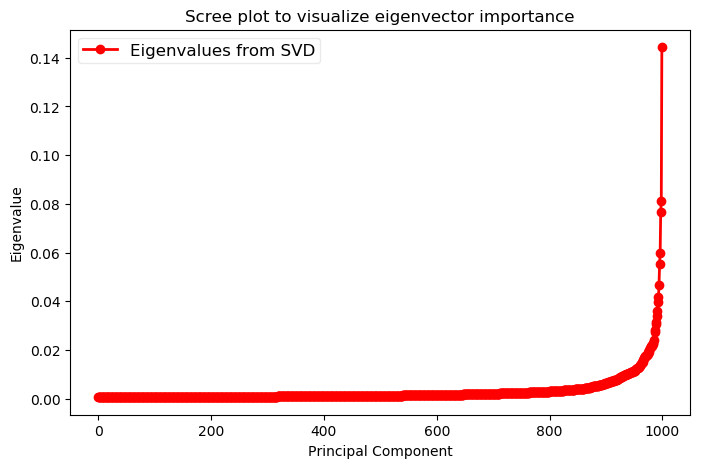

In [15]:
# Visualize eigenvalue magnitudes to determine appropriate LSA cutoff
features.plot_scree(1000)

In [21]:
# Apply LSA using finite number of eigenvectors - use knee of Scree plot or >50% variance explained
nLSA=135
features.apply_lsa(nLSA)

Variance Explained: 0.5021024560934627


# Clustering Analyses

With our feature matrix set, we can now perform various clustering analyses to assign documents to categories.  Two standard clustering algorithms are implemented below: K-means clustering and Gaussian mixture modeling (GMM).  GMM is a more robust method that implements probabilistic assignment and more flexibility in the shapes of the clusters, so it is usually recommended.  However, in practice, I find k-means clustering often provides useful, straightforward results that sometimes distinguishes clusters that match the eye-test better than GMM. It's important to try both and understand how results differ.

First, we initialize a clustering object that will then store results from each type of clustering analysis using the same feature matrix.  This allows for easy comparing between methods using the same object.  In addition, we use TSNE to map our multi-dimensional LSA space to two dimensions to allow for visualization of document locations and clusters later on.  This mapping is done using a subsample of the entire corpus to reduce computational burden.  Usually using 33-50% of the total number of documents still allows one to visualize and see clear cluster differentiation, even if not all documents are taken into account.  NOTE: This only affects visualization - the actual clustering is performed on ALL documents.

In [22]:
# Initialize clustering object
clustering = clust.Clustering(corpus.dfCorpus, corpus.dfTopics, features.matLSA,
                              svd = features.svd)

# Create TSNE subsample of corpus for plotting
# NOTE: use subsampl=len(self.dfCorpus) to use entire corpus
clustering.create_tsne(subsmpl=4000)

## K-Means Clustering

For k-means clustering, we must first determine the optimal number of clusters to use by maximizing the silhouette score.  The method k_means_opt performs clustering on a range of cluster numbers from minCluster to maxCluster, and then calculates the silhouette score on a test set.  You should use the cluster number where the silhouette score maximizes or peaks.

Current cluster number: 20
Current cluster number: 40
Current cluster number: 60
Current cluster number: 80
Current cluster number: 100
Current cluster number: 120
Current cluster number: 140


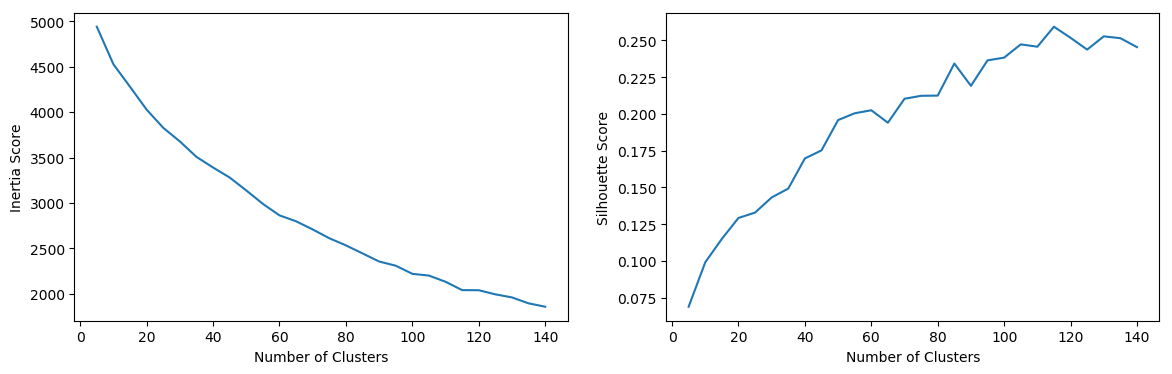

In [23]:
# Optimize number of clusters based on silhouette score
maxSilScore, silScores = clustering.k_means_opt(minCluster=5, maxCluster=140, interval=5,
                                                silFraction=1.0, testSize = 0.25, plot=True)
print(maxSilScore)

Now, use the optimized cluster number to run k-means clustering.  The kmThemes output will provide a dataframe with a number of rows equal to the number of clusters.  Each column will include keywords from the vocabulary associated with that cluster.  This information is helpful for labeling or describing cluster content.

In [26]:
# Create k-means clusters
nClustKM = 115
kmThemes = clustering.k_means_clustering(numCluster=nClustKM)

In [27]:
kmThemes

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,Document Count
0,hierarchical,tio2,superhydrophobic,nanosheets,microspheres,macroporous,nanoparticles,co3o4,dyes,hierarchical flower,47
1,films,silicon,plasma,wafer,doped,siox,antireflection,annealing,substrate temperature,laser,33
2,triplet,energy systems,foam,thermoelectric,nanosheets,bodipy,ammonia,polyelectrolytes,moo3,coumarin,620
3,films,copolymers,hierarchical,arrays,roll,power,annealing,transparent,monolayer,membranes,11
4,zno,doped,films,doped zno,zno thin films,co doping,transparent,nanospheres,azo films,ceramic,75
5,skin,uvb,pigmentation,photoaging,patients,keratinocytes,lesion,cancer,uvr,uva,67
6,batteries,power,grid,flow batteries,energy systems,vehicles,dispatch,flexible,sodium ions,forecasted,82
7,power,grid,power flow,mppt,self powered,batteries,distribution network,algorithm,hybridly powered,inverter,207
8,algorithm,power,mppt,partial shading,fuzzy,grid,learning,fault,boost converter,tracker,55
9,zno,films,photocatalytic,zno nanorods,nanoparticles,doped zno,zno thin films,nanorods,nanocomposites,nws,184


Now that we have cluster labels, we can plot the cluster centers along with the subsampled documents using the results of the above TSNE transformation.  Sometimes, 4 or 5 documents may be mapped to distances extremely far away form all other documents.  In those cases, you can set inXlim and inYlim limits to focus the graph on the vast majority of the documents and clusters (you can set these two parameters to None to visualize the entire space). <br />

There are several reasons why documents do not cluster well with the rest of the group.  Typically, this is due to those documents including a small number of words (possibly not having an abstract), so our limited selection of Topics to create dfTopics or LSA eigenvectors did not capture any of their content.  Increasing the number of topics or LSA eigenvectors typically resolves this issue.

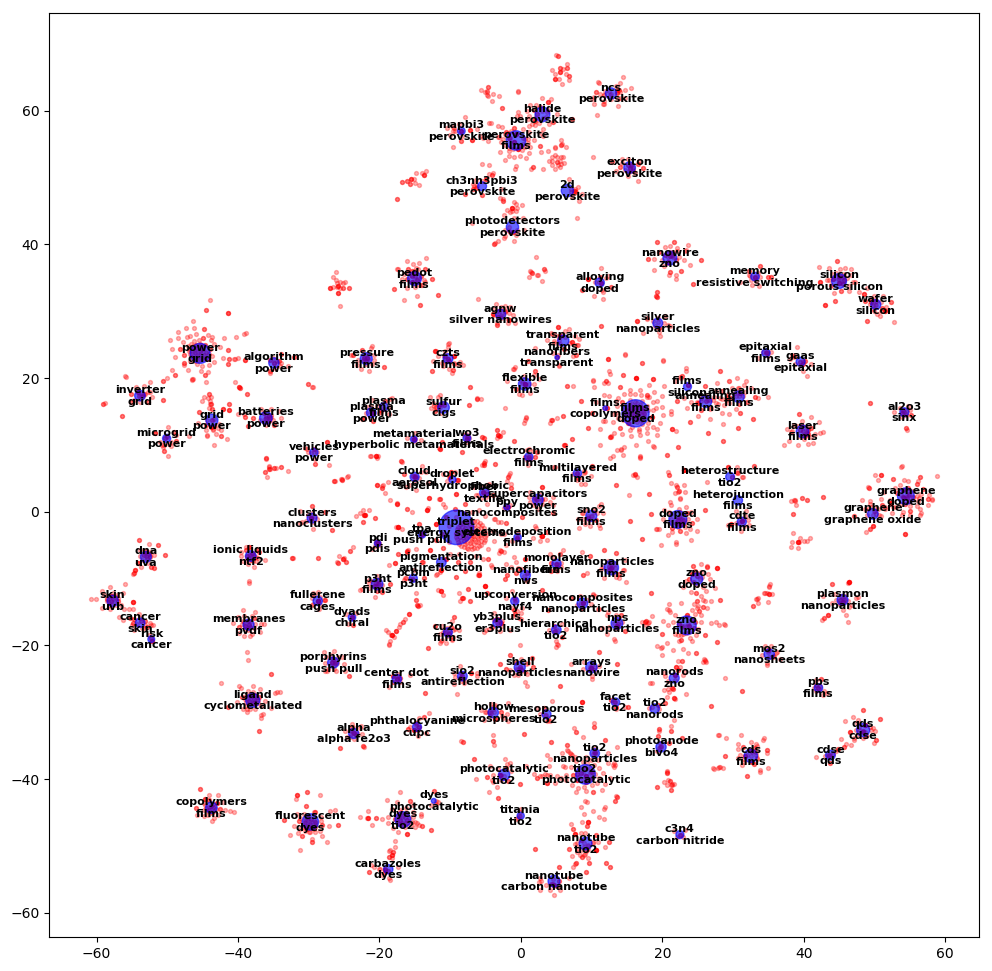

In [29]:
# Create 2D mapping using TSNE with subsample of total documents
kmThemesTSNE = clustering.apply_tsne(kmThemes, 'KM',
                                     inXlim=None, inYlim=None, plot=True)

## Gaussian Mixture Modeling

Now, we can follow the same procedure for Gaussian Mixture Modeling.  Instead of a silhouette score, for GMM your aim is to minimize the AIC and BIC scores, which both indicate how much information the model is providing.  BIC scores more severely penalize more complex models (complexity here being measured by the number of clusters), so it will always recommend a smaller number.  I find that AIC minimization generally matches silhouette maximization for k-means clustering to a closer degree, and often better represents the actual data.

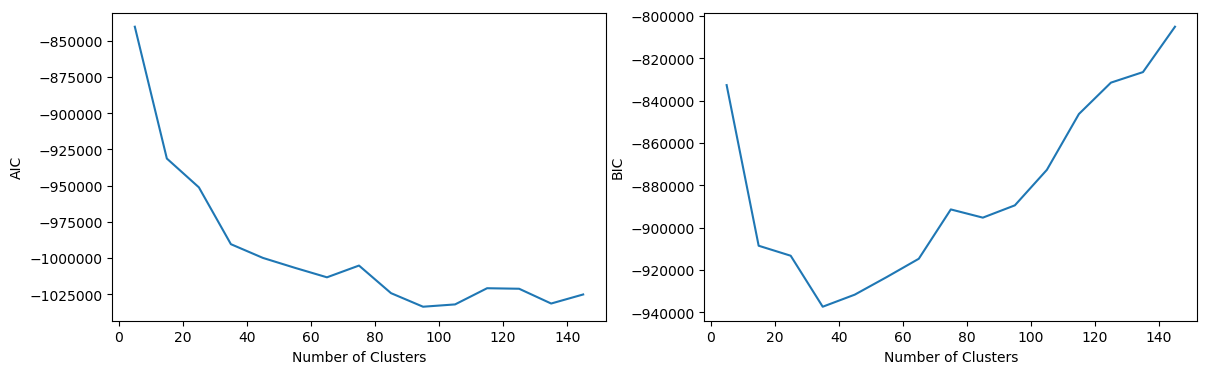

In [30]:
# Optimize number of clusters based on AIC/BIC scores
# NOTE: Often it's difficult to find a minimum with 'full' covariance matrix and high-dimensional data
# NOTE: 'full' covariance is prone to overfitting and works poorly for small datasets
# Recommend using 'tied' or 'diag' covariance types
minAIC, minBIC, AIC, BIC = clustering.gmm_opt(minCluster=5, maxCluster=150, interval=10,
                                              testSize=0.25, covarType='diag', plot=True)

In [31]:
# Calculate GM clusters using optimized number of clusters
nClustGM = 105
gmThemes = clustering.gmm_clustering(numCluster=nClustGM, covarType='diag')

In [32]:
# Compute probabilities of each document belonging to each cluster
dfGMclusterProb = pd.DataFrame(clustering.GMmodel.predict_proba(clustering.featMatrix))

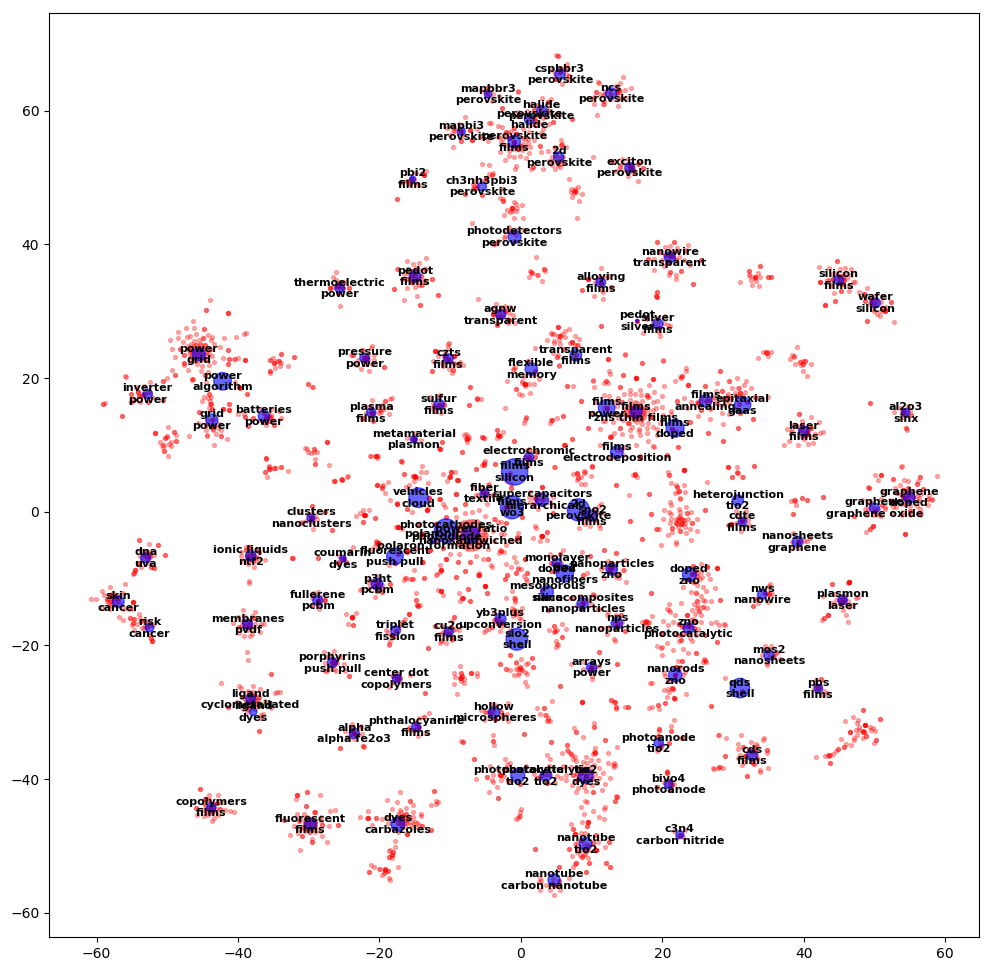

In [33]:
# Create 2D mapping using TSNE with subsample of total documents
gmThemesTSNE = clustering.apply_tsne(gmThemes, 'GM',
                                     inXlim=None, inYlim=None, plot=True)

That's the general process!  Now we can save the themes for each cluster for k-means and GMM to file, along with the entire corpus that now contains a new column with its k-means and GM category labels ('KM Cluster Label' and 'GM Cluster Label' columns, respectively):

In [35]:
corpus.dfCorpus.head()

,Unnamed: 0,Abstract,Addresses,Authors,Authors WoS,Category: Research,Category: WoS,DOI,Funding Text,ISSN,...,Publication Type,Publication Year,Source,Times Cited,Title,UID,Corpus,Corpus Stemmed,KM Cluster Label,GM Cluster Label
0,16091,The modifications produced by 55 MeV Si4+ swif...,"Malaviya Natl Inst Technol, Dept Phys, Jaipur ...","Sharma, Trupti; Singhal, Rahul; Vishnoi, Ritu;...","Sharma, T; Singhal, R; Vishnoi, R; Lakshmi, GB...",Instruments & Instrumentation; Nuclear Science...,Instruments & Instrumentation; Nuclear Science...,10.1016/j.nimb.2017.02.003,Authors are thankful to Inter University Accel...,0168-583X,...,Journal,2017-01-01,NUCLEAR INSTRUMENTS & METHODS IN PHYSICS RESEA...,1,Influence of high energy ion irradiation on fu...,WOS:000397698500002,influence of high energy ion irradiation on fu...,influenc of high energi ion irradi on fulleren...,81,46
1,16092,Doping enables the effective tuning of the pro...,"Zhejiang Univ, State Key Lab Silicon Mat, Hang...","Yuan, T. H.; Pi, X. D.; Yang, D.","Yuan, TH; Pi, XD; Yang, D",Engineering; Optics; Physics,"Engineering, Electrical & Electronic; Optics; ...",10.1109/JSTQE.2017.2654058,This work was supported by the National Basic ...,1077-260X,...,Journal,2017-01-01,IEEE JOURNAL OF SELECTED TOPICS IN QUANTUM ELE...,2,Nonthermal Plasma Synthesized Boron-Doped Germ...,WOS:000398941200001,nonthermal plasma synthesized boron doped germ...,nontherm plasma synthes boron dope germanium n...,37,91
2,16093,Self-assembled cadmium sulfide (CdS) thin soli...,"Univ Fed Uberlandia, Inst Phys, Av Engenheiro ...","Rabelo, Adriano Cesar; da Silva, Marco A. T.; ...","Rabelo, AC; da Silva, MAT; Alcalde, AM; Lauret...",Chemistry; Science & Technology - Other Topics...,"Chemistry, Multidisciplinary; Nanoscience & Na...",10.1166/jnn.2017.12475,Financial support from FAPESP (Fundacao de Amp...,1533-4880,...,Journal,2017-01-01,JOURNAL OF NANOSCIENCE AND NANOTECHNOLOGY,0,Photoluminescence Study of Ammonium-Free Chemi...,WOS:000397106600104,photoluminescence study of ammonium free chemi...,photoluminesc studi of ammonium free chemic ba...,31,42
3,16094,Graphene has attracted enormous interests due ...,"Chinese Acad Sci, Key Lab Microelect Devices &...","Lu, Nianduan; Wang, Lingfei; Li, Ling; Liu, Ming","Lu, ND; Wang, LF; Li, L; Liu, M",Physics,"Physics, Multidisciplinary",10.1088/1674-1056/26/3/036804,Project supported by the Opening Project of Ke...,1674-1056,...,Journal,2017-01-01,CHINESE PHYSICS B,2,A review for compact model of graphene field-e...,WOS:000396129200044,a review for compact model of graphene field e...,a review for compact model of graphen field ef...,103,15
4,16095,Narrow bandgap and hyperbranched polymers (h-P...,"Nanyang Technol Univ, Sch Chem & Biomed Engn, ...","Wang, Kai; Wang, Mingfeng","Wang, K; Wang, MF",Polymer Science,Polymer Science,10.1002/pola.28464,M.W. thanks the funding support by a start-up ...,0887-624X,...,Journal,2017-01-01,JOURNAL OF POLYMER SCIENCE PART A-POLYMER CHEM...,4,Hyperbranched Narrow-Bandgap DPP Homopolymers ...,WOS:000393885600010,hyperbranched narrow bandgap dpp homopolymers ...,hyperbranch narrow bandgap dpp homopolym synth...,29,79


In [36]:
# Save relevant dataframes to file
kmThemesTSNE.to_csv('KM_themes.csv')
gmThemesTSNE.to_csv('GM_themes.csv')
corpus.dfCorpus.to_csv('Corpus.csv')

At this point, you can now use the category labels to create topic-normalized citation impact scores.  This calculation involves finding the average Times Cited within a category, year, and document type, and dividing the Times Cited by this value for all documents within that group.  The index provides a helpful way to compare bibliometric citations to an expected citation rate within a given technology.